## Blackjack simulation: Counting cards

Jacob L. Fine

June 21st, 2024

We will simulate a game of Blackjack, with two players: one is counting cards, and the other is not. We will pass through 1000 rounds in 10 simulations with different 'shuffling thresholds'. The shuffling theshold will be defined as the proportion of cards remaining after a given number of iterations that forces the dealer to shuffle the decks.

The rules of the game are simple: the player and the dealer are initially dealt two cards, and the player must decide to hit or stay. The dealer only shows one of the two cards. If the sum of the cards in the player's hand is larger than 21 after any number of hits, or if it is smaller than the dealers by the end of the game, then player loses. And if at any point, the dealer's hand is larger than 21, the player wins. Aces count as 11 unless they would result in going over 21 (a 'bust'), in which case they are counted as 1. 

The idea behind counting cards is to have a count that predicts the number of high cards still present in the deck/shoe. The higher the count, the more likely we are to place a larger bet. We adjust a count in our minds that goes up when we observe low cards in our hand or the dealer's hand, and goes down when there are high cards. This is because the increased frequency of low cards on the table is inversely proportional to the frequency of high cards remaining in the deck. One method to count cards is known as Hi-Lo, which increases the count by 1 if the a dealt card is between 2 and 6, and decreases it if a dealt card is between 10 and Ace. In this program, the counting cards method will only impact the amount bet by the card counter, so we will compare the long-run total balances with all else being equal for the two players.

All of these rules, and the others not described above, are coded below, with more detailed descriptions found in the comments. 



.
..
...
||| _________________________ ROUND 0, 20% threshold_________________________ 
||| Player hand: ['10', '6', '10'], value: 26
||| Dealer hand: ['8', '7', 'K'], value: 25
||| Outcome: Dealer wins!
||| Counter balance: $1000.00, Non-counter balance: $990.00
||| Cards remaining: 100.0%
...
..
.

.
..
...
||| _________________________ ROUND 250, 20% threshold_________________________ 
||| Player hand: ['K', 'J'], value: 20
||| Dealer hand: ['J', '2', 'K'], value: 22
||| Outcome: Player wins!
||| Counter balance: $985.00, Non-counter balance: $916.00
||| Cards remaining: 64.42%
...
..
.

.
..
...
||| _________________________ ROUND 500, 20% threshold_________________________ 
||| Player hand: ['J', '2', '10'], value: 22
||| Dealer hand: ['8', '7', '10'], value: 25
||| Outcome: Dealer wins!
||| Counter balance: $951.00, Non-counter balance: $829.00
||| Cards remaining: 31.73%
...
..
.

.
..
...
||| _________________________ ROUND 750, 20% threshold_________________________ 
||| Play

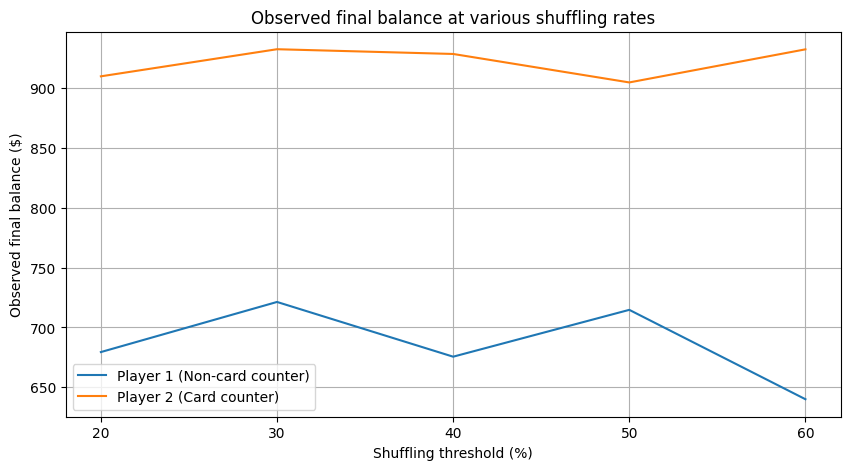

In [122]:
import random
import matplotlib.pyplot as plt

# this dictionary stores all the card values
card_value_dict = {
    '2': 2, '3': 3, '4': 4, '5': 5, '6': 6,
    '7': 7, '8': 8, '9': 9, '10': 10,
    'J': 10, 'Q': 10, 'K': 10, 'A': 11
}


# this function will generate a number of decks and then shuffle them
def generate_deck(num_decks):
    # simply creates a deck based on the card values, but can create any number of decks
    deck = [card for card in card_value_dict for _ in range(4 * num_decks)] 

    # shuffles the deck
    random.shuffle(deck)
    # returns the deck
    return deck

# determines the value of the current hand
def determine_hand_value(hand):
    # sums the values of the cards currently present in the hand
    value = sum(card_value_dict[card] for card in hand)
    # counts the number of aces in the hand
    num_aces = hand.count('A')
    # if the value of the hand would exceed 21, we now want to apply the rule that we treat aces as 1s to prevent a bust
    while value > 21 and num_aces:
    # now, to treat aces as 1 instead of 11, we subtract 10 from the current value and drop the number of aces by 1 to exit the while loop
        value -= 10
        num_aces -= 1
    return value

# the initial hands are dealt here, we remove the last two cards from the deck by popping them, both for the player and the dealer
# we also store the card the dealer is showing, which will inform the decision of the player whether to hit or not
# we also return the deck, which now lacks four cards that were removed
def deal_starting_hands(deck):
    player_hand = [deck.pop() for _ in range(2)]
    dealer_hand = [deck.pop() for _ in range(2)]
    dealer_up_card = dealer_hand[0]  # Dealer's up card is the first card in their hand
    return player_hand, dealer_hand, dealer_up_card, deck


# this is the function that represents hitting, we directly pop another card from the deck and append it to the player's hand 
# we then return the updated hand and deck
def hit(hand, deck):
    hand.append(deck.pop())
    return hand, deck


# the decision function of whether to hit or not is probabilistic based on certain conditions
def decision_function_for_hitting(hand, dealer_up_card):
    player_hand_value = determine_hand_value(hand)
    
    # we store the dealer's up card to help inform the player's decision
    dealer_up_card_value = card_value_dict[dealer_up_card]
    
    # We now go through severval conditions. If the player's hand is above 17, we must stand
    if player_hand_value >= 17:
        return False
    
    # We also stand when the dealer's card is 6 or lower, and the player's hand is 12 or higher
    if dealer_up_card_value <= 6 and player_hand_value >= 12:
        return False

    # Now, if all these conditions are satisfied, we hit with a probability of 0.9. This adds some randomness into our program which may be desirable.
    if random.random() < 0.90:  # 90% probability to hit
        return True
    else:
        return False


# This is our card counting method. We are here using the Hi-Lo system, Card counting using Hi-Lo system, see: https://en.wikipedia.org/wiki/Card_counting
# Here, a higher count increases the amount we are willing to bet, since more dealt lower cards indicates more high cards are undealt. We bet accordingly
# Formally, if the dealt card is between 2 and 6, we increase our count by 1, and if it is between 10 and Ace, we decrease count by 1.
def hi_lo_count_cards(card, count):
    if card in ['2', '3', '4', '5', '6']:
        count += 1
    elif card in ['10', 'J', 'Q', 'K', 'A']:
        count -= 1
    return count


# Simulates blackjack, with a shuffling rate shuffling_threshold
def play_rounds_of_blackjack(num_rounds,shuffling_threshold,num_decks,sim_num):
    sim_num = sim_num # the current number of simulation
    deck = generate_deck(num_decks)  # only generates the deck once at the start of the game, but can do this more
    count = 0
    player1_balance = 1000  # Non-card counter
    player2_balance = 1000  # Card counter
    print_limit = 250 # how often to print, i.e., every 50 iterations
    
    
    for _ in range(num_rounds+1):

        round_num = _
        # keeps track of proportion of cards remaining
        proportion_cards_remaining = round((len(deck)/(52*num_decks))*100,2)
        if (proportion_cards_remaining < shuffling_threshold): # if less than K% of the cards are left, time for a re-shuffle!
            deck = generate_deck(num_decks)
            count = 0 # we reset our count whenever there is a shuffle!

        
        # Deal initial hands and get dealer's up card
        player_hand, dealer_hand, dealer_up_card, deck = deal_starting_hands(deck)
        for card in player_hand + dealer_hand:
            count = hi_lo_count_cards(card, count)
        
        # player1 makes a random bet each time, and player2 uses the count method
        player1_bet = random.randint(0,10)

        # we use our count to inform our bet. The size of the bet we place is proportional to our count. But sometimes our count can be 0 or less, so we bet 1 in those cases.
        # Here, we divide our count by 4 to determine the exact bet, but this is an arbitary choice.
        player2_bet = max(0, count // 2)  
        
        # Only while the function that allows us to hit is returning true, we hit. Recall the conditions that enable us to hit with a 0.9 probability.
        while decision_function_for_hitting(player_hand, dealer_up_card):
            # we return the current hand and deck from the function that does the hitting, which involves popping a card from the deck and appending it to our hand.
            player_hand, deck = hit(player_hand, deck)
            # now, we update the count, based on what the player has in their hand
            count = hi_lo_count_cards(player_hand[-1], count)
        
        # we now store what the value of the dealer's hand is
        dealer_value = determine_hand_value(dealer_hand)

        # the dealer must hit if their hand is below 17
        while dealer_value < 17:
            # dealer's hand is updated
            dealer_hand, deck = hit(dealer_hand, deck)
            # we determine the new value of the dealer's hand
            dealer_value = determine_hand_value(dealer_hand)
            # this enables us to update our current count for counting cards
            count = hi_lo_count_cards(dealer_hand[-1], count)
        
        # we again determine the values of the current hands
        player_value = determine_hand_value(player_hand)
        dealer_value = determine_hand_value(dealer_hand)
        
        # we now determine who won, and print relevant results
        if round_num % print_limit== 0 and sim_num == 1:  # we only want to print some of the results, for the first sim
            print('')
            print('.')
            print('..')
            print('...')
            print(f'||| _________________________ ROUND {round_num}, {shuffling_threshold}% threshold_________________________ ')
            print(f'||| Player hand: {player_hand}, value: {player_value}')
            print(f'||| Dealer hand: {dealer_hand}, value: {dealer_value}')


        # checks if the player has a 'natural' blackjack
        if player_value == 21 and len(player_hand) == 2 and ('A' in player_hand) and ('10' in player_hand):
            if round_num % print_limit== 0 and sim_num == 1:  # we only want to print some of the results, for the first sim
                print('||| Outcome: Player wins, with a natural blackjack!')

            player1_balance += int(1.5 * player1_bet) 
            player2_balance += int(1.5 * player2_bet)  
        
        # the rules of the game, i.e., if the player's hand is above 21, they lose. We update their balances accordingly
        elif player_value > 21:
            if round_num % print_limit== 0 and sim_num == 1:  # we only want to print some of the results, for the first sim
                print('||| Outcome: Dealer wins!')

            player1_balance -= player1_bet
            player2_balance -= player2_bet
        # if the dealer is over 21, or if the player hand has a higher value than the dealer hand, the player wins

        elif dealer_value > 21 or player_value > dealer_value:
            if round_num % print_limit== 0 and sim_num == 1:  # we only want to print some of the results, for the first sim
                print('||| Outcome: Player wins!')
            player1_balance += player1_bet
            player2_balance += player2_bet
        
        # the dealier wins if the player value is less than the dealer value
        elif player_value < dealer_value:
            if round_num % print_limit== 0 and sim_num == 1:  # we only want to print some of the results, for the first sim
                print('||| Outcome: Dealer wins!')
            player1_balance -= player1_bet
            player2_balance -= player2_bet
        # it is a tie (a.k.a. 'push') if the values are equal
        elif player_value == dealer_value:
            if round_num % print_limit== 0 and sim_num == 1:  # we only want to print some of the results, for the first sim
                print('||| Outcome: Push!')


        # Print current balances
        if round_num % print_limit== 0 and sim_num == 1:  # we only want to print some of the results, for the first sim
            print(f'||| Counter balance: ${player2_balance}.00, Non-counter balance: ${player1_balance}.00')
            print(f'||| Cards remaining: {proportion_cards_remaining}%')
            print('...')
            print('..')
            print('.')
    if sim_num == 1:
        print(f'---------------------END-OF-SIMULATION-FOR-{shuffling_threshold}%-THRESHOLD---------------------')
    return player1_balance, player2_balance


# Function to simulate the game for varying number of decks
def simulate_many_blackjack_games(shuffling_threshold_list, num_simulations, num_rounds):
    player1_observed_values = []
    player2_observed_values = []
    
    for shuffling_threshold in shuffling_threshold_list:
        player1_final_balances = []
        player2_final_balances = []
        
        for sim_num in range(num_simulations):
            player1_final_balance, player2_final_balance = play_rounds_of_blackjack(num_rounds, shuffling_threshold, num_decks,sim_num)
            player1_final_balances.append(player1_final_balance)
            player2_final_balances.append(player2_final_balance)
        
        observed_value_player1 = sum(player1_final_balances) / num_simulations
        observed_value_player2 = sum(player2_final_balances) / num_simulations
        
        player1_observed_values.append(observed_value_player1)
        player2_observed_values.append(observed_value_player2)
    
    return player1_observed_values, player2_observed_values

# Define the range of deck counts to test, and the shuffling rate
num_decks = 6

# shuffle when the number of cards left is below this
shuffling_threshold_list = range(20,70,10)
num_simulations = 30
num_rounds = 1000

# Simulate the game
player1_observed_values, player2_observed_values = simulate_many_blackjack_games(shuffling_threshold_list, num_simulations, num_rounds)

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(shuffling_threshold_list, player1_observed_values, label='Player 1 (Non-card counter)')
plt.plot(shuffling_threshold_list, player2_observed_values, label='Player 2 (Card counter)')
plt.xticks(shuffling_threshold_list)
plt.xlabel('Shuffling threshold (%)')
plt.ylabel('Observed final balance ($)')
plt.title('Observed final balance at various shuffling rates')
plt.legend()
plt.grid(True)
plt.show()


In the above, we see that the card counter beats the non-card counter fairly consistently, irrespective of shuffling rate! It is important to note, however, that in the real-world the decision making process is more complex than that simulated by the code.

Also, we have only printed out a subset of the total samples, to minimize the use of space. There are in fact 30 simulations per setting, with 1000 rounds per simulation.